In [1]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setu

In [2]:
!nvidia-smi

Fri Sep 20 22:30:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from torch_geometric.nn import RGCNConv

from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Load graph
view=4
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/content/drive/MyDrive/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [7]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [8]:
# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [9]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [10]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

In [11]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [12]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 1612030  Test:460580  Validation: 230290


In [13]:
## EXTERNAL TEST SETS

## VIEW 0-2
#test_sets = ['miRNA-disease2bepred']
#test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [14]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 61], [True, 15679]]


In [15]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def encode(self, x, edge_index, edge_type):
        edge_type = edge_type.view(-1)
        x = self.conv1(x, edge_index, edge_type).relu()
        return self.conv2(x, edge_index, edge_type)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [16]:
num_relations = len(pred_mapping)
model = Net(train_data.num_features, 32, 64, num_relations).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [17]:
def train():
    model.train()
    optimizer.zero_grad()

    # Flatten edge_type to make sure it's 1D
    edge_type = train_data.edge_type.view(-1)  # Ensure it's 1D

    z = model.encode(train_data.x, train_data.edge_index, edge_type)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()


In [18]:
@torch.no_grad()
def test(data):
    model.eval()
    edge_type = data.edge_type.view(-1)  # Ensure edge_type is 1D

    z = model.encode(data.x, data.edge_index, edge_type)

    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


In [19]:
@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index, data.edge_type)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()

    # Ensure edge_type is 1D
    edge_type = data.edge_type.view(-1)  # Flatten edge_type to be 1D if necessary

    # Check edge_index dimensions
    if data.edge_index.dim() != 2 or data.edge_index.size(0) != 2:
        raise ValueError(f"Expected edge_index with shape [2, num_edges], but got {data.edge_index.shape}")

    z = model.encode(data.x, data.edge_index, data.edge_type)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

In [20]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 206.2832
Epoch: 002, Loss: 83.8636
Epoch: 003, Loss: 51.0805
Epoch: 004, Loss: 40.5762
Epoch: 005, Loss: 36.5907
Epoch: 006, Loss: 34.3298
Epoch: 007, Loss: 30.1205
Epoch: 008, Loss: 25.1092
Epoch: 009, Loss: 20.9068
Epoch: 010, Loss: 18.1184
Epoch: 011, Loss: 15.7273
Epoch: 012, Loss: 13.4238
Epoch: 013, Loss: 11.3722
Epoch: 014, Loss: 9.9116
Epoch: 015, Loss: 8.8635
Epoch: 016, Loss: 8.0092
Epoch: 017, Loss: 7.3573
Epoch: 018, Loss: 6.7878
Epoch: 019, Loss: 6.2547
Epoch: 020, Loss: 5.7404
Epoch: 021, Loss: 5.2902
Epoch: 022, Loss: 4.8459
Epoch: 023, Loss: 4.3929
Epoch: 024, Loss: 3.9625


In [21]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 3.5541
Epoch: 002, Loss: 3.2024
Epoch: 003, Loss: 2.9424
Epoch: 004, Loss: 2.7237
Epoch: 005, Loss: 2.5194
Epoch: 006, Loss: 2.3656
Epoch: 007, Loss: 2.2283
Epoch: 008, Loss: 2.1032
Epoch: 009, Loss: 2.0069
Epoch: 010, Loss: 1.9201
Epoch: 011, Loss: 1.8447
Epoch: 012, Loss: 1.7673
Epoch: 013, Loss: 1.6967
Epoch: 014, Loss: 1.6141
Epoch: 015, Loss: 1.5504
Epoch: 016, Loss: 1.4912
Epoch: 017, Loss: 1.4199
Epoch: 018, Loss: 1.3696
Epoch: 019, Loss: 1.3263
Epoch: 020, Loss: 1.2795
Epoch: 021, Loss: 1.2437
Epoch: 022, Loss: 1.2113
Epoch: 023, Loss: 1.1823
Epoch: 024, Loss: 1.1570
Epoch: 025, Loss: 1.1321
Epoch: 026, Loss: 1.1087
Epoch: 027, Loss: 1.0930
Epoch: 028, Loss: 1.0744
Epoch: 029, Loss: 1.0561
Epoch: 030, Loss: 1.0366
Epoch: 031, Loss: 1.0217
Epoch: 032, Loss: 1.0085
Epoch: 033, Loss: 0.9862
Epoch: 034, Loss: 0.9775
Epoch: 035, Loss: 0.9650
Epoch: 036, Loss: 0.9497
Epoch: 037, Loss: 0.9409
Epoch: 038, Loss: 0.9290
Epoch: 039, Loss: 0.9189
Epoch: 040, Loss: 0.9078


In [22]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.8385
Epoch: 002, Loss: 0.8356
Epoch: 003, Loss: 0.8313
Epoch: 004, Loss: 0.8237
Epoch: 005, Loss: 0.8230
Epoch: 006, Loss: 0.8165
Epoch: 007, Loss: 0.8145
Epoch: 008, Loss: 0.8088
Epoch: 009, Loss: 0.8065
Epoch: 010, Loss: 0.7995
Epoch: 011, Loss: 0.7987
Epoch: 012, Loss: 0.7958
Epoch: 013, Loss: 0.7908
Epoch: 014, Loss: 0.7878
Epoch: 015, Loss: 0.7834
Epoch: 016, Loss: 0.7819
Epoch: 017, Loss: 0.7802
Epoch: 018, Loss: 0.7770
Epoch: 019, Loss: 0.7749
Epoch: 020, Loss: 0.7726
Epoch: 021, Loss: 0.7693
Epoch: 022, Loss: 0.7680
Epoch: 023, Loss: 0.7663
Epoch: 024, Loss: 0.7641


In [23]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.7609
Epoch: 002, Loss: 0.7594
Epoch: 003, Loss: 0.7580
Epoch: 004, Loss: 0.7539
Epoch: 005, Loss: 0.7547
Epoch: 006, Loss: 0.7512
Epoch: 007, Loss: 0.7499
Epoch: 008, Loss: 0.7477
Epoch: 009, Loss: 0.7465
Epoch: 010, Loss: 0.7446
Epoch: 011, Loss: 0.7422
Epoch: 012, Loss: 0.7401
Epoch: 013, Loss: 0.7392
Epoch: 014, Loss: 0.7378
Epoch: 015, Loss: 0.7366
Epoch: 016, Loss: 0.7350
Epoch: 017, Loss: 0.7334
Epoch: 018, Loss: 0.7326
Epoch: 019, Loss: 0.7309
Epoch: 020, Loss: 0.7307
Epoch: 021, Loss: 0.7291
Epoch: 022, Loss: 0.7272
Epoch: 023, Loss: 0.7250
Epoch: 024, Loss: 0.7255
Epoch: 025, Loss: 0.7235
Epoch: 026, Loss: 0.7226
Epoch: 027, Loss: 0.7204
Epoch: 028, Loss: 0.7198
Epoch: 029, Loss: 0.7188
Epoch: 030, Loss: 0.7175
Epoch: 031, Loss: 0.7162
Epoch: 032, Loss: 0.7158
Epoch: 033, Loss: 0.7151
Epoch: 034, Loss: 0.7139
Epoch: 035, Loss: 0.7126
Epoch: 036, Loss: 0.7120
Epoch: 037, Loss: 0.7101
Epoch: 038, Loss: 0.7093
Epoch: 039, Loss: 0.7093
Epoch: 040, Loss: 0.7086


In [24]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6988
Epoch: 002, Loss: 0.6985
Epoch: 003, Loss: 0.6986
Epoch: 004, Loss: 0.6984
Epoch: 005, Loss: 0.6965
Epoch: 006, Loss: 0.6953
Epoch: 007, Loss: 0.6939
Epoch: 008, Loss: 0.6942
Epoch: 009, Loss: 0.6936
Epoch: 010, Loss: 0.6923
Epoch: 011, Loss: 0.6923
Epoch: 012, Loss: 0.6921
Epoch: 013, Loss: 0.6901
Epoch: 014, Loss: 0.6909
Epoch: 015, Loss: 0.6891
Epoch: 016, Loss: 0.6902
Epoch: 017, Loss: 0.6883
Epoch: 018, Loss: 0.6875
Epoch: 019, Loss: 0.6875
Epoch: 020, Loss: 0.6861
Epoch: 021, Loss: 0.6851
Epoch: 022, Loss: 0.6845
Epoch: 023, Loss: 0.6852
Epoch: 024, Loss: 0.6839
Epoch: 025, Loss: 0.6828
Epoch: 026, Loss: 0.6835
Epoch: 027, Loss: 0.6833
Epoch: 028, Loss: 0.6812
Epoch: 029, Loss: 0.6819
Epoch: 030, Loss: 0.6809
Epoch: 031, Loss: 0.6809
Epoch: 032, Loss: 0.6792
Epoch: 033, Loss: 0.6795
Epoch: 034, Loss: 0.6787
Epoch: 035, Loss: 0.6791
Epoch: 036, Loss: 0.6784
Epoch: 037, Loss: 0.6782
Epoch: 038, Loss: 0.6770
Epoch: 039, Loss: 0.6757
Epoch: 040, Loss: 0.6768


In [25]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6713
Epoch: 002, Loss: 0.6714
Epoch: 003, Loss: 0.6705
Epoch: 004, Loss: 0.6720
Epoch: 005, Loss: 0.6711
Epoch: 006, Loss: 0.6693
Epoch: 007, Loss: 0.6700
Epoch: 008, Loss: 0.6696
Epoch: 009, Loss: 0.6685
Epoch: 010, Loss: 0.6689
Epoch: 011, Loss: 0.6684
Epoch: 012, Loss: 0.6680
Epoch: 013, Loss: 0.6673
Epoch: 014, Loss: 0.6675
Epoch: 015, Loss: 0.6666
Epoch: 016, Loss: 0.6664
Epoch: 017, Loss: 0.6657
Epoch: 018, Loss: 0.6662
Epoch: 019, Loss: 0.6653
Epoch: 020, Loss: 0.6653
Epoch: 021, Loss: 0.6641
Epoch: 022, Loss: 0.6647
Epoch: 023, Loss: 0.6642
Epoch: 024, Loss: 0.6639
Epoch: 025, Loss: 0.6637
Epoch: 026, Loss: 0.6638
Epoch: 027, Loss: 0.6634
Epoch: 028, Loss: 0.6622
Epoch: 029, Loss: 0.6618
Epoch: 030, Loss: 0.6621
Epoch: 031, Loss: 0.6625
Epoch: 032, Loss: 0.6611
Epoch: 033, Loss: 0.6619
Epoch: 034, Loss: 0.6602
Epoch: 035, Loss: 0.6603
Epoch: 036, Loss: 0.6595
Epoch: 037, Loss: 0.6600
Epoch: 038, Loss: 0.6592
Epoch: 039, Loss: 0.6592
Epoch: 040, Loss: 0.6591


In [26]:
# Training
n_epochs=51

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6563
Epoch: 002, Loss: 0.6571
Epoch: 003, Loss: 0.6566
Epoch: 004, Loss: 0.6565
Epoch: 005, Loss: 0.6561
Epoch: 006, Loss: 0.6563
Epoch: 007, Loss: 0.6555
Epoch: 008, Loss: 0.6552
Epoch: 009, Loss: 0.6553
Epoch: 010, Loss: 0.6549
Epoch: 011, Loss: 0.6539
Epoch: 012, Loss: 0.6545
Epoch: 013, Loss: 0.6548
Epoch: 014, Loss: 0.6541
Epoch: 015, Loss: 0.6533
Epoch: 016, Loss: 0.6534
Epoch: 017, Loss: 0.6538
Epoch: 018, Loss: 0.6527
Epoch: 019, Loss: 0.6529
Epoch: 020, Loss: 0.6523
Epoch: 021, Loss: 0.6522
Epoch: 022, Loss: 0.6525
Epoch: 023, Loss: 0.6513
Epoch: 024, Loss: 0.6522
Epoch: 025, Loss: 0.6515
Epoch: 026, Loss: 0.6510
Epoch: 027, Loss: 0.6516
Epoch: 028, Loss: 0.6508
Epoch: 029, Loss: 0.6504
Epoch: 030, Loss: 0.6508
Epoch: 031, Loss: 0.6511
Epoch: 032, Loss: 0.6511
Epoch: 033, Loss: 0.6498
Epoch: 034, Loss: 0.6494
Epoch: 035, Loss: 0.6497
Epoch: 036, Loss: 0.6499
Epoch: 037, Loss: 0.6501
Epoch: 038, Loss: 0.6493
Epoch: 039, Loss: 0.6502
Epoch: 040, Loss: 0.6483


In [27]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6472
Epoch: 002, Loss: 0.6472
Epoch: 003, Loss: 0.6462
Epoch: 004, Loss: 0.6463
Epoch: 005, Loss: 0.6472
Epoch: 006, Loss: 0.6469
Epoch: 007, Loss: 0.6463
Epoch: 008, Loss: 0.6459
Epoch: 009, Loss: 0.6463
Epoch: 010, Loss: 0.6458
Epoch: 011, Loss: 0.6453
Epoch: 012, Loss: 0.6456
Epoch: 013, Loss: 0.6452
Epoch: 014, Loss: 0.6451
Epoch: 015, Loss: 0.6444
Epoch: 016, Loss: 0.6451
Epoch: 017, Loss: 0.6450
Epoch: 018, Loss: 0.6442
Epoch: 019, Loss: 0.6448
Epoch: 020, Loss: 0.6445
Epoch: 021, Loss: 0.6444
Epoch: 022, Loss: 0.6443
Epoch: 023, Loss: 0.6444
Epoch: 024, Loss: 0.6436


In [28]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')

 View: 4, Train: 0.8658544655756533, Val: 0.8575


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [30]:
z = get_emb(train_data)

In [31]:
y= nodes_df['type'].astype('category').cat.codes

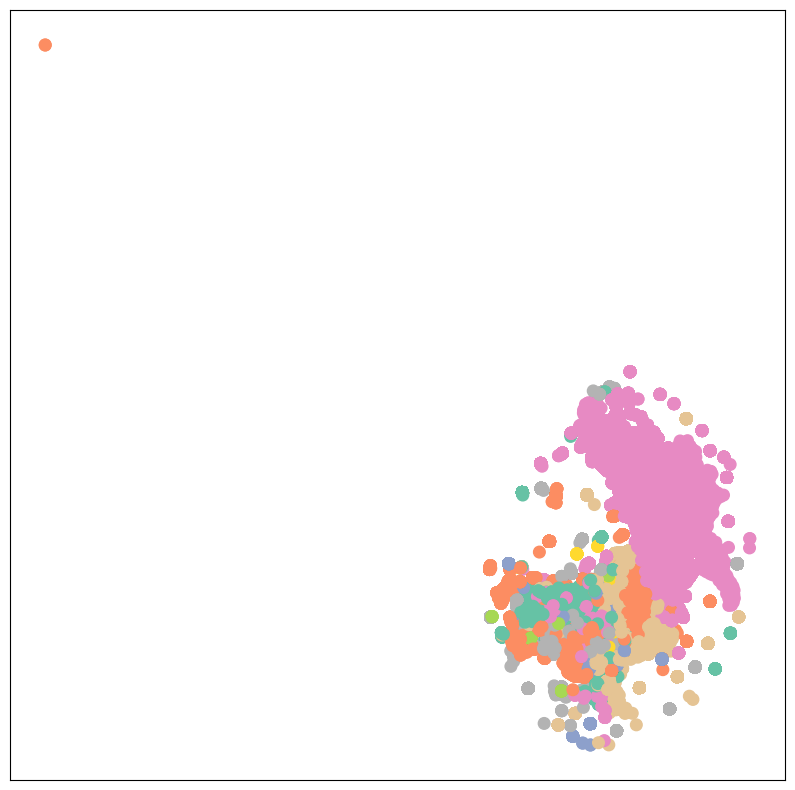

In [32]:
visualize(z,y)

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

<ipython-input-33-33f9d704249d>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


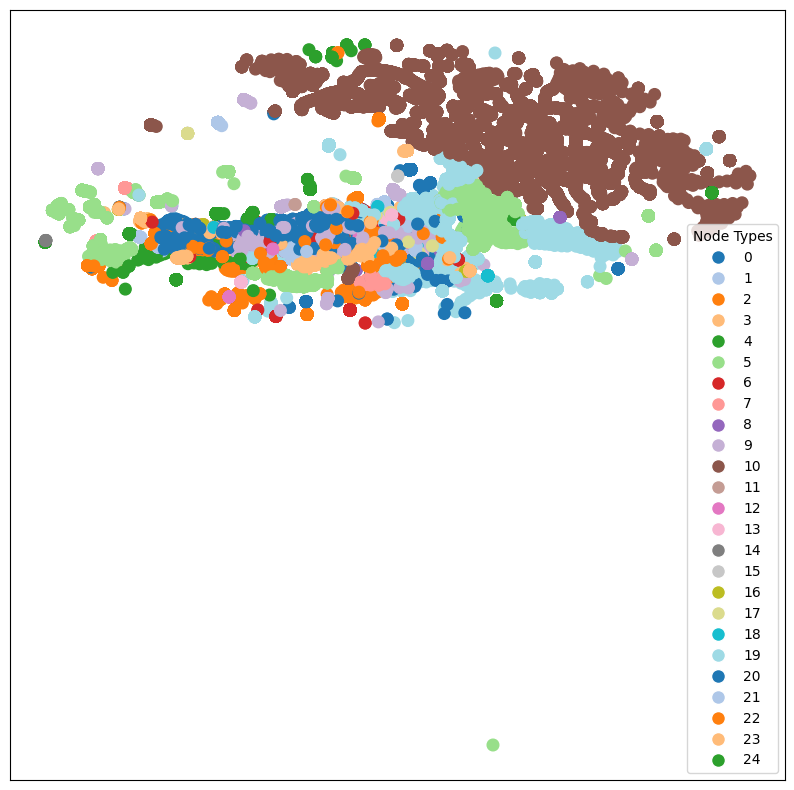

In [34]:
visualize(z,y)

In [35]:
torch.save(model, view_path+'RGCNConv_model_view'+str(view)+'.pth')

In [36]:
import os

# Define the directory and file path
view =1
view_path = f'/content/drive/MyDrive/VIEW{view}/'
predictions_path = os.path.join(view_path, 'predictions')
file_path = os.path.join(predictions_path, f'view{view}_GNN_node_embeddings.csv')

# Ensure the directory exists
os.makedirs(predictions_path, exist_ok=True)

In [37]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
probs.to_csv(view_path+'predictions/view'+str(view)+'_GNN_node_embeddings.csv')

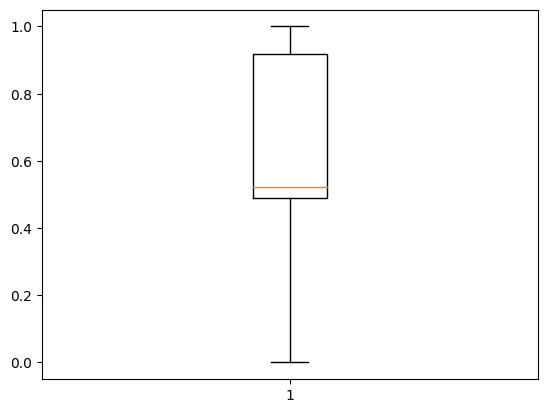

In [38]:
_=plt.boxplot(get_prob(test_data))

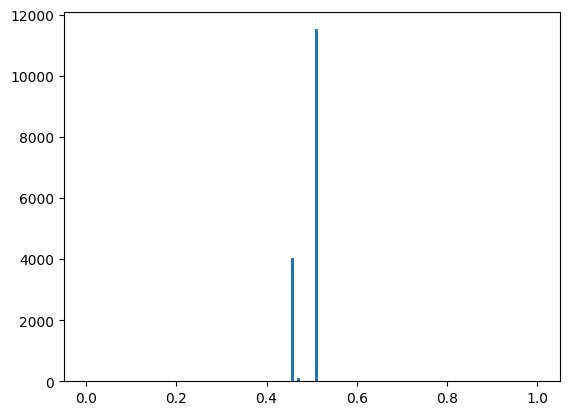

In [39]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [40]:
nodes_df

,name,type
0,<http://www.ncbi.nlm.nih.gov/gene/1163>,Gene
1,<http://purl.obolibrary.org/obo/GO_1902115>,GO
2,<http://purl.obolibrary.org/obo/MONDO_0009301>,Disease
3,<http://www.ncbi.nlm.nih.gov/gene/2692>,Gene
4,<http://purl.obolibrary.org/obo/MONDO_0000535>,Disease
...,...,...
85294,<http://purl.obolibrary.org/obo/UBERON_0035110>,Anatomy
85295,<https://www.mirbase.org/mature/MIMAT0002841>,miRNA
85296,<http://purl.obolibrary.org/obo/CHEBI_36834>,Chemical
85297,<http://purl.obolibrary.org/obo/HP_0500107>,Phenotype


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = z
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [43]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9847
Precision: 0.9859
Recall: 0.9847


In [44]:
from grape import Graph
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [45]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [46]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)

Evaluating on VIEW4_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/225 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/57 [00:00<?, ?it/s]

In [47]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINEv4rg.csv"
results.to_csv(filename)

In [48]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,recall,informedness,threat_score,prevalence,fall_out,accuracy,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.183778,0.001989,0.155508,0.5,0.181789,0.500994,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.155053,-0.027166,0.131154,0.5,0.182219,0.486417,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.183585,0.001682,0.155330,0.5,0.181903,0.500841,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.155826,-0.025676,0.131888,0.5,0.181502,0.487162,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.183879,0.000816,0.155426,0.5,0.183062,0.500408,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.154445,-0.028086,0.130605,0.5,0.182532,0.485957,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.183668,0.001501,0.155366,0.5,0.182167,0.500751,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.155817,-0.025993,0.131846,0.5,0.181811,0.487003,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.183967,0.001815,0.155620,0.5,0.182152,0.500908,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.153798,-0.029446,0.129980,0.5,0.183244,0.485277,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
